In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import transformers
import os, json, glob, requests, torch, cv2
import numpy as np
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [ ]:
#set default path
TRAIN_JSON_PATH = '/content/drive/MyDrive/감정따뜻쟁이/label/train/'
VALID_JSON_PATH = '/content/drive/MyDrive/감정따뜻쟁이/label/val/'
TEST_JSON_PATH = '/content/drive/MyDrive/감정따뜻쟁이/TEST_DATA_SET/label/'

TRAIN_IMG_PATH = '/content/drive/MyDrive/감정따뜻쟁이/img/train/'
VALID_IMG_PATH = '/content/drive/MyDrive/감정따뜻쟁이/img/val/'
TEST_IMG_PATH = '/content/drive/MyDrive/감정따뜻쟁이/TEST_DATA_SET/TEST_DATA_SET/'

TRAIN_SEGMENT_PATH = 'data/segmentation/train/'
VALID_SEGMENT_PATH = 'data/segmentation/val/'

IMG_ROWS = 256
IMG_COLS = 256

In [ ]:
def get_json_list_1d(json_folder_path): #returns a 1 dim array
    temp_loader = []
    json_train = []
    emotion_list_json = os.listdir(json_folder_path)

    for emotion in emotion_list_json:
        with open (json_folder_path + emotion, "r", encoding='euc-kr') as f:
            temp_loader.append(json.load(f))

    for i in range(len(temp_loader)):
        json_train += temp_loader[i]

    return json_train

In [ ]:
def load_image_and_label_1D(json_list, img_path):
    img_file = []
    label_list = []

    eng_to_num = { '분노'   : '0',
                   '기쁨'   : '1',
                   '당황'   : '2',
                   '슬픔'   : '3'
                 }
    kr_to_en = { '분노'    : 'anger',
                 '기쁨'   : 'happy',
                 '당황'   : 'panic',
                 '슬픔'   : 'sadness'
                 }


    for entry in range(len(json_list)):
        try:
            label = json_list[entry]['faceExp_uploader']
            img_dir = img_path + kr_to_en[label] + '/' + json_list[entry]['filename']
            # img = np.array(image.load_img(img_dir, target_size=(IMG_ROWS, IMG_COLS)))/255
            img = image.load_img(img_dir, target_size=(IMG_ROWS, IMG_COLS))
            img_file.append(img)
            label_list.append(int(eng_to_num[label]))
        except Exception:
            print("Emotion " + label + " " + json_list[entry]['filename'] + " Not available")
            pass

    return img_file, label_list

In [ ]:
json_train = get_json_list_1d(TRAIN_JSON_PATH)
json_val = get_json_list_1d(VALID_JSON_PATH)
json_test = get_json_list_1d(TEST_JSON_PATH)

In [ ]:
train_img, train_label = load_image_and_label_1D(json_train, TRAIN_IMG_PATH)

Emotion 기쁨 7zwecfe6e57f975ee8b238b355e3e87923c4557383daae96720c1b8c3f669g9m2.jpg Not available
Emotion 기쁨 oxmt62fbb28fafcdaa8d64e75a332e1d506d6a079cb45fc9e00c576c40fbeo0wy.jpg Not available
Emotion 기쁨 s1mu862ea97f26b2720eeecb51156f6e32e8523fd62f3f04ef2f727639f52d7g3.jpg Not available
Emotion 당황 twdva8d723865fa1005873a6967797c75f3dd83197f13f7daa3e3926947071al6.jpg Not available
Emotion 당황 5yid6d7ae32bf14b1343da46cfdb3fdffc8e1c64baf4fb1b175690f648a870v69.jpg Not available
Emotion 당황 bpv531e5cebdb1c00085158bb0677c5596ccabf1c8a5cb0007991571bf306wcd4.jpg Not available
Emotion 당황 s1q397a38900c1e1f950496109900e7c01f0630459790d8590010655c4090vlh0.jpg Not available
Emotion 당황 7m2k46c05803855399ea1ee1911875ee59e05640c93135c0bc91b5660456cdo8k.jpg Not available
Emotion 당황 n55yc741f09701506c7eb5ba30533db35c905ab5bf0597b5652ece03c5950ozv1.jpg Not available
Emotion 당황 bid7b3c93409e1d83514689337f6d3d63a338339d71c9ce7fded153d3576fk2ml.jpg Not available
Emotion 당황 if0lfc4b517c6597e3656dbea350e406e1b5ae4

In [ ]:
test_img, test_label = load_image_and_label_1D(json_test, TEST_IMG_PATH)

Emotion 슬픔 ifea34779bc9499b4f097bb10954a5b7c7bb022a0c4d9d579cb745d79b784d94q.jpg Not available
Emotion 슬픔 xje3c2677a87f22fc3e161778238e79f20c0f325e47decf5717bf314c118dxvkf.jpg Not available
Emotion 슬픔 svbp8d38f3d8cc0298d648fd83192c1d19e5d47ec3170229811dae5d701f7hhqg.jpg Not available
Emotion 슬픔 s14i4268fb0c02c3fc3bc8098aff482aa2d0df83309b8653b98f23099c2405qle.jpg Not available
Emotion 슬픔 qowu6f7daf646767025c832b68d04b6dc980ba9330f6f0fc66a2798899f56i6d4.jpg Not available
Emotion 슬픔 qluk354be7972497a9904a3051776e9ee0534b39cd4f7ebdb9eb0395eacc4yadr.jpg Not available
Emotion 슬픔 vvmf32ee632062d1d5671f44b631c10fe363a59825deed8246f29cc2d2004mgdt.jpg Not available
Emotion 슬픔 ujeab4cc92528bcf165e4545b27e86255c13bd23b6e5c306fb92983b8998cmh1z.jpg Not available
Emotion 슬픔 u0h57bd9de787700ff0a08d144a7a8a2a907f9d1297dfa474699dd06070a80fh8.jpg Not available
Emotion 슬픔 vppg68d12cf7965a99814525ec2393e7c2040d8f7988e2d6b32d91c22237eix1o.jpg Not available
Emotion 슬픔 vl08e207d6c4e7a07af5dd7744c8334fcf9c2c2

In [ ]:
val_img, val_label = load_image_and_label_1D(json_val, VALID_IMG_PATH)

Emotion 슬픔 b14secfe2b1749c94c7cc563020df10e40372c7b9c8dbe793779c6c2cb272cznr.jpg Not available


In [ ]:
train_images = np.array(train_img)
train_labels = np.array(train_label)

val_images = np.array(val_img)
val_labels = np.array(val_label)

test_images = np.array(test_img)
test_labels = np.array(test_label)

In [ ]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 15.5 MB/s eta 0:00:00


In [ ]:
num_classes = 4
input_shape = (256, 256, 3)

In [ ]:
batch_size = 256

image_size = 224
patch_size = 32
num_patches = (image_size // patch_size)**2

projection_dim = 64
num_heads = 4

transformer_units = [
    projection_dim*2,
    projection_dim,
]

transformer_layers = 12
mlp_head_units = [2048, 1024]

In [ ]:
from tensorflow.keras import layers
import tensorflow_addons as tfa
import tensorflow as tf
from keras.models import Sequential
from tensorflow import keras

In [ ]:
data_augmentation = tf.keras.Sequential([

                  layers.Normalization(),
                  layers.Resizing(image_size, image_size),
                  layers.RandomFlip('horizontal'),
                  layers.RandomRotation(factor = 0.02),
                  layers.RandomZoom(height_factor = 0.2, width_factor = 0.2),
                  ],
                  name = 'data_augmentation',
)

data_augmentation.layers[0].adapt(total_images)

In [ ]:
def mlp(x, hidden_units, dropout_rate):
  for units in hidden_units:
    x = layers.Dense(units, activation = tf.nn.gelu)(x)
    x = layers.Dropout(dropout_rate)(x)
  return x

In [ ]:
class Patches(layers.Layer):
  def __init__(self, patch_size):
    super(Patches, self).__init__()
    self.patch_size = patch_size

  def call(self, images):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(

        images = images,
        sizes = [1, self.patch_size, self.patch_size, 1],
        strides = [1, self.patch_size, self.patch_size, 1],
        rates = [1, 1, 1, 1],
        padding = "VALID",
    )
    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size, -1, patch_dims])
    return patches

Image size : 224 X 224
Pathc size : 32 X 32
Patches per image :49
3072
(1, 49, 3072)


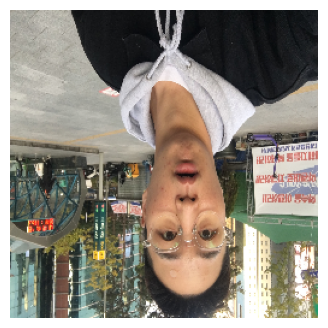

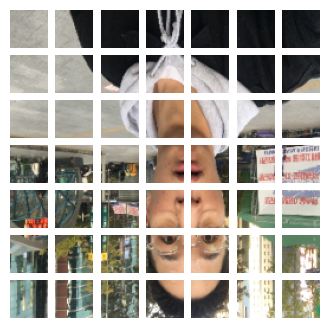

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize = (4, 4))
image = train_images[np.random.choice(range(train_images.shape[0]))]
plt.imshow(image.astype('uint8'))
plt.axis('off')

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size = (image_size, image_size)
)

patches = Patches(patch_size)(resized_image)
print(f'Image size : {image_size} X {image_size}')
print(f'Pathc size : {patch_size} X {patch_size}')
print(f'Patches per image :{patches.shape[1]}')
print(f'{patches.shape[-1]}')
print(f'{patches.shape}')

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize = (4, 4))
for i, patch in enumerate(patches[0]):
  ax = plt.subplot(n, n, i+1)
  patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
  plt.imshow(patch_img.numpy().astype('uint8'))
  plt.axis('off')

In [ ]:
class PatchEncoder(layers.Layer):
  def __init__(self, num_patches, projection_dim):
    super(PatchEncoder, self).__init__()
    self.num_patches = num_patches

    self.projection = layers.Dense(units = projection_dim)
    self.position_embedding = layers.Embedding(
        input_dim = num_patches, output_dim = projection_dim
    )

  def call(self, patch):
    position = tf.range(start=0, limit=self.num_patches, delta = 1)
    encoded = self.projection(patch) + self.position_embedding(position)
    return encoded


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

def vit():

  inputs = layers.Input(shape = input_shape)

  augmented = data_augmentation(inputs)

  patches = Patches(patch_size)(augmented)

  encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

  for _ in range(transformer_layers):

    x1 = layers.LayerNormalization(epsilon = 1e-6)(encoded_patches)

    attention_output = layers.MultiHeadAttention(
        num_heads = num_heads, key_dim = projection_dim, dropout = 0.1
    )(x1, x1)

    x2 = layers.Add()([attention_output, encoded_patches])

    x3 = layers.LayerNormalization(epsilon = 1e-6)(x2)

    x3 = mlp(x3, hidden_units = transformer_units, dropout_rate = 0.1)

    encoded_patches = layers.Add()([x3, x2])

  representation = layers.LayerNormalization(epsilon = 1e-6)(encoded_patches)
  representation = layers.Flatten()(representation)
  representation = layers.Dropout(0.5)(representation)

  features = mlp(representation, hidden_units = mlp_head_units, dropout_rate = 0.5)
  logits = layers.Dense(num_classes)(features)

  model = Model(inputs = inputs, outputs = logits)
  return model

In [ ]:
model = vit()

In [ ]:
num_epochs = 20
learning_rate = 0.001


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, weight_decay = 0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = [
        keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
    ]
)

history = model.fit(
    train_images,
    train_labels,
    batch_size = batch_size,
    epochs = num_epochs,
    validation_split = 0.1,
    #validation_data = (val_images, val_labels),
)

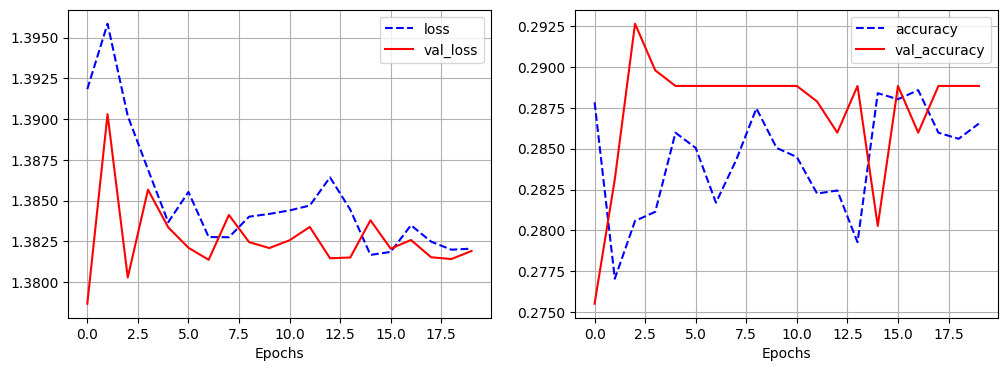

In [ ]:
plt.figure(figsize = (12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b--', label = 'loss')
plt.plot(history.history['val_loss'], 'r', label = 'val_loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'b--', label = 'accuracy')
plt.plot(history.history['val_accuracy'], 'r', label = 'val_accuracy')
plt.xlabel('Epochs')
plt.grid()
plt.legend()